<h2>Google Timeline JSON Data Formatting</h2>

Author: Andy Bartle <br>
Date: 17/03/2019

In [115]:
import json
import datetime
import pandas as pd

### Import Google Timeline data to a Pandas dataframa

Download data from: https://takeout.google.com/settings/takeout

In [156]:
# Load google timeline data from JSON file
G_timeline = r"Input_Data/LocationHistory20190319.json"
with open(G_timeline) as data_file:
    data = json.load(data_file)
    df = pd.DataFrame.from_dict(data['locations'])

In [157]:
# View a sample of the data
def check_df(df):
    ''' Prints DataFrame row count, column count and 5 random data rows '''
    rows, columns = df.shape
    print("Rows: {}, columns: {}".format(rows, columns))
    return df.sample(5)
check_df(df)

Rows: 1180115, columns: 9


,accuracy,activity,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy
357512,500,NaN,NaN,NaN,515486409,-1078369,1458980183098,NaN,NaN
366115,20,NaN,NaN,NaN,515494679,-1089803,1460610038482,NaN,NaN
646521,20,NaN,80.0,NaN,515636157,-997184,1497934445218,NaN,NaN
764710,17,"[{'timestampMs': '1515823546546', 'activity': ...",671.0,NaN,454509560,65693052,1515823516192,NaN,2.0
1696,20,"[{'timestampMs': '1368829559356', 'activity': ...",NaN,NaN,395775014,-1051379104,1368829587834,NaN,NaN


### Clean data

1. Create date time index
2. Convert lat/long from E7 to standard values
3. Drop columns
4. Remove rows with a location accuracy below threshold

In [158]:
# Return a date/time value from timestamp
def date_time(value):
    ''' Return date time value from time stamp '''
    import tzlocal
    dataTimezone = timezone('Europe/London')
    timeStamp = float(value) # time stamp in ms
    dateTime = datetime.datetime.fromtimestamp(timeStamp/1000.0, dataTimezone)
    return dateTime

# Call function
df['Datetime'] = df.timestampMs.apply(date_time)

# Set datetime value as DataFrame index
df = df.set_index('Datetime')

In [159]:
# Covert lat and long from E7 format (expoent 1e7) to standard
df['latitude'] = df.latitudeE7 / 1e7
df['longitude'] = df.longitudeE7 / 1e7

In [160]:
# Drop columns we don't need
df = df.drop(['latitudeE7', 'longitudeE7', 'timestampMs', 'activity', 'altitude', 'verticalAccuracy', 'heading', 'velocity'], axis=1)

In [161]:
# Filter out values with an accuracy greater than minimum threshold
accuracyLimit = 100
df = df[df['accuracy'] <= accuracyLimit]

In [162]:
check_df(df)

Rows: 1054550, columns: 3


,accuracy,latitude,longitude
Datetime,,,
2018-09-22 12:44:42+01:00,10,46.192274,7.814483
2016-11-26 23:53:29.090000+00:00,18,51.549503,-0.108990
2017-08-25 16:48:41.795000+01:00,37,51.544872,-0.107121
2018-05-27 00:29:48.217000+01:00,50,51.572475,-0.068388
2017-05-15 09:24:01.733000+01:00,24,51.503752,-0.104037


In [163]:
# Save to CSV
#G_timeline_cleaned = r"Output_Data/LocationHistory_cleaned.csv"
#df.to_csv(G_timeline_cleaned)

### Make it spatial

In [58]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
%matplotlib inline
import contextily as ctx

In [164]:
# Filter by dates
arrLondon = "2015-03-28"
leaveLondon = "2018-11-06"

vanTripStart = "2018-08-07"
vanTripEnd = "2018-10-19"

fromDate = arrLondon
toDate = leaveLondon

# Apply filter
df_filtered = df.loc[fromDate:toDate]
df_filtered = df_filtered.copy()

In [165]:
check_df(df_filtered)

Rows: 817098, columns: 3


,accuracy,latitude,longitude
Datetime,,,
2016-04-29 13:23:02.277000+01:00,72,51.504035,-0.105041
2017-09-12 09:58:54.491000+01:00,18,51.503701,-0.103681
2018-08-17 17:58:00+01:00,10,43.642572,5.973811
2017-05-15 16:59:50.272000+01:00,23,51.531548,-0.111079
2017-11-10 18:32:37+00:00,20,51.557964,-0.090457


In [166]:
# Create GeoDataFrame from filter subset
def df_to_gdf(df):
    '''
    Create a Geopandas GeoDataFrame from a Pandas DataFrame and convert to web mercator
    '''
    # Create a tuple coordinates column for shapely object in geodataframe
    df['Coordinates'] = list(zip(df.longitude, df.latitude))
    # Transform tuples to points
    df['Coordinates'] = df['Coordinates'].apply(Point)
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry='Coordinates')
    # Convert to web mercator
    gdf.crs = {'init' :'epsg:4326'} # not projected, decimal degrees
    gdf = gdf.to_crs(epsg=3857) # projected, meters
    # Return geopandas geodataframe
    return gdf

gdf = df_to_gdf(df_filtered)

In [167]:
check_df(gdf)

Rows: 817098, columns: 4


,accuracy,latitude,longitude,Coordinates
Datetime,,,,
2017-03-24 07:31:44.302000+00:00,20,51.549585,-0.108898,POINT (-12122.48104035611 6719090.814437924)
2016-08-30 22:00:51.429000+01:00,17,51.549503,-0.108990,POINT (-12132.68903766058 6719076.081342155)
2018-04-27 20:40:04.544000+01:00,27,51.561060,-0.099056,POINT (-11026.88574391636 6721145.312937663)
2018-04-06 07:45:51.909000+01:00,25,51.545374,-0.102377,POINT (-11396.53324504567 6718336.95452488)
2017-09-08 13:20:27.026000+01:00,20,51.503618,-0.103842,POINT (-11559.60516710801 6710866.159470554)


### Create maps

In [168]:
# Plot filtered timeline data on map

def plot_map(gdf, title):
    ''' Function plots gdf and returns a map '''
    # Helper function for basemap
    def add_basemap(ax, zoom):
        ''' Helper function to download tiles for map extent '''
        # URLs, mapbox basemaps: https://docs.mapbox.com/api/maps/#styles
        # stamenUrl = 'http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'
        mapboxAccessToken = 'pk.eyJ1IjoiYmFydGxlYW5keSIsImEiOiJjajIzbjc0bTkwMDFhMnFwamI0ZWZob204In0.PgaQcYB6AKm4TqzL1kQzMQ'
        mapboxUrl = "https://api.mapbox.com/styles/v1/mapbox/outdoors-v11/tiles/tileZ/tileX/tileY?access_token="+mapboxAccessToken
        # Set URL
        url = mapboxUrl
        # Get tiles
        xmin, xmax, ymin, ymax = ax.axis()
        basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
        ax.imshow(basemap, extent=extent, interpolation='bilinear')
        ax.axis((xmin, xmax, ymin, ymax))

    # Create Matplotlib figure
    fig, ax = plt.subplots(figsize=(10, 10))    

    # Set Axes
    # Comment this out to set map extent to data extent
    # GLA
    ax.set_xlim([-65000, 40000])
    ax.set_ylim([6670000, 6744000])
    # Central London
    #ax.set_xlim([-30000, 6000])
    #ax.set_ylim([6700000, 6730000])
    # Van trip
    #ax.set_xlim([-386895, 2194219])
    #ax.set_ylim([4300670, 6839098])
    
    # Remove axes ticks
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.tick_params(bottom=False, left=False)

    # Title
    #ax.set(title='My time in London')
    plt.annotate(title, xy=(4, 10), xycoords='axes points', size=25)

    # Plot gdf
    gdf.plot(ax=ax, color = 'black', markersize=1, alpha=0.05)

    # Add basemap
    add_basemap(ax, zoom=10)
    
    # Return map
    return fig

def save_map(fig, date, name, outputFolder):
    ''' Save map '''
    # Save image
    imageName = name
    imageDate = date
    imageDPI = 150
    fig.savefig(outputFolder + "\{}_{}_{}dpi.png".format(imageName, imageDate, imageDPI), dpi=imageDPI, bbox_inches="tight")

### Static map

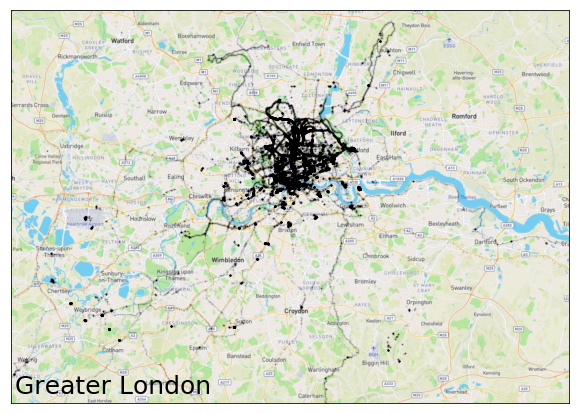

In [142]:
# Create static map
# PLot map
title = "Greater London"
mapFig = plot_map(gdf, title)

# Save map
date = "20190412"
name = "GreaterLondon"
outputFolder = "Output_Data"
save_map(mapFig, date, name, outputFolder)

### Animated map

In [169]:
# Define dates to loop through for animation
def dates_London():
    ''' London '''
    datesDict = {}
    years = ["2015", "2016", "2017", "2018"]
    monthNo = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    monthWord = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
    for y in years:
        for n in range(12):
            keyEntry = y + "-" + monthNo[n]
            valueEntry = y + " " + monthWord[n]
            datesDict.update({keyEntry: valueEntry})
    return datesDict

def dates_van():
    ''' Van trip'''
    datesDict = {}
    vanTripStart = "2018-08-07"
    vanTripEnd = "2018-10-19"
    datelist = pd.date_range(vanTripStart, vanTripEnd).tolist()
    for n in datelist:
        datetimeval = n.to_pydatetime()
        keyEntry = datetimeval.date()
        valueEntry = datetimeval.strftime("%B")
        datesDict.update({keyEntry: valueEntry})
    return datesDict

In [170]:
# Loop dates dictionary and save maps

# Dates
datesDict = dates_London()

# Loop
for key, value in datesDict.items():   
    # Filter by dates
    fromDate = fromDate
    toDate = str(key)
    gdf_filtered = gdf.loc[fromDate:toDate]
    
    # Plot map
    mapFig = plot_map(gdf_filtered, value)
    
    # Save map
    date = toDate
    name = "GreaterLondon"
    outputFolder = r"Output_Data\GreaterLondonAnimation_v2"
    save_map(mapFig, date, name, outputFolder)
    
    # Close plot
    plt.close()

In [171]:
# Combine images into a gif
import imageio
import os

# List images
imagesFolder = outputFolder
filenames = os.listdir(imagesFolder)

# Create gif
movieFile = imagesFolder + '\\' + 'movie.gif'
with imageio.get_writer(movieFile, mode='I', duration=0.3) as writer:
    for filename in filenames:
        image = imageio.imread(imagesFolder + "\\" + filename)
        writer.append_data(image)